# Compare average acceleration over hours of the day between matched controls and cases

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import pylab as plt

from scipy import stats
from statannot import add_stat_annotation
import pingouin as pg

from importlib import reload
import sys
import os
sys.path.insert(1,'../')
import plots

In [2]:
reload(plots)
image_path = plots.set_dir()
colors = plots.set_colors()
data_path = '/scratch/c.c21013066/data/ukbiobank/phenotypes/accelerometer/'

/scratch/c.c21013066/docker/envs/pythonstats/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/tmp/ipykernel_234574/3803790436.py:48: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pvals.to_latex())


\begin{tabular}{llll}
\toprule
       &                    &         t &    pvalue \\
group & hour &           &           \\
\midrule
diagHC & Average0000\_\_\_0059 &  0.545644 &  0.585535 \\
       & Average0100\_\_\_0159 & -0.539497 &  0.589765 \\
       & Average0200\_\_\_0259 & -1.758402 &  0.079241 \\
       & Average0300\_\_\_0359 & -1.688227 &  0.091941 \\
       & Average0400\_\_\_0459 & -1.113506 &  0.265983 \\
       & Average0500\_\_\_0559 & -0.352558 &  0.724556 \\
       & Average0600\_\_\_0659 &  1.119013 &  0.263629 \\
       & Average0700\_\_\_0759 &  4.161234 &  0.000037 \\
       & Average0800\_\_\_0859 &  5.446083 &       0.0 \\
       & Average0900\_\_\_0959 &  7.823464 &       0.0 \\
       & Average1000\_\_\_1059 &  7.315273 &       0.0 \\
       & Average1100\_\_\_1159 &  7.921877 &       0.0 \\
       & Average1200\_\_\_1259 &  7.368594 &       0.0 \\
       & Average1300\_\_\_1359 &  7.195227 &       0.0 \\
       & Average1400\_\_\_1459 &  6.917191 &       0.

/tmp/ipykernel_234574/3803790436.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xnames,rotation=90);


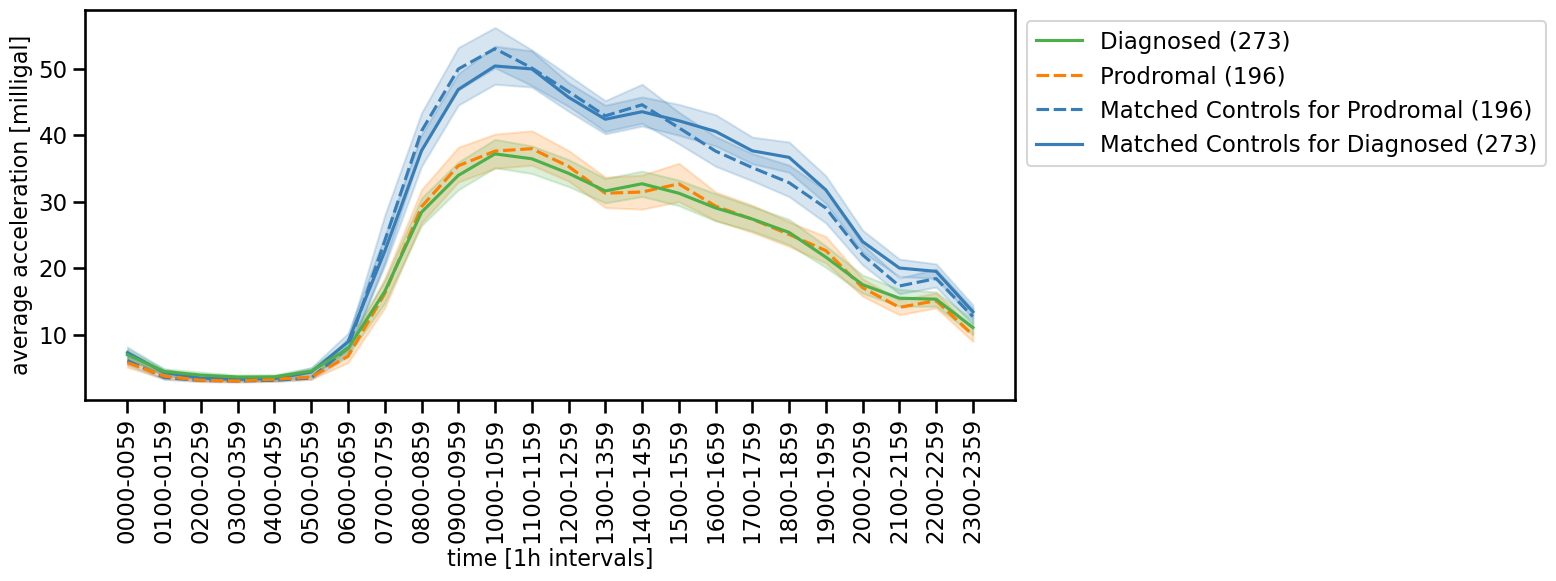

In [3]:
dfs_new = pd.read_csv(f'{data_path}matched_all_HCnoOsteo.csv',index_col=0)
for name in ['Osteoarthritis','ParkinsonDisease','Depression','AllCauseDementia']:
    if name == 'ParkinsonDisease':
        matched_sample = dfs_new[dfs_new['diagnosis']==name]

        time_matched = matched_sample[np.hstack([name,'diagnosis','diagnosis_prod','diagnosis_prod_conservative','Group',matched_sample.filter(regex='Average').columns,'visit_age',f'{name}_age','time_to_diagnosis','accelerometry_age','acc_time_since_diagnosis'])]
        time_matched = time_matched.melt(id_vars=[name,'accelerometry_age','time_to_diagnosis','acc_time_since_diagnosis','diagnosis','diagnosis_prod','diagnosis_prod_conservative',f'{name}_age','Group'],
                                         value_vars=matched_sample.filter(regex='Average').columns)

        matched = 'matched'
        for diag in ['Group']:
            time_matched['match'] = time_matched[diag].replace(['Prodromal','Diseased','Healthy_Prodromal',
                                                                'Healthy_Diseased'],
                                                          ['prodromal','diseased','prodromal','diseased'])
            time_matched['status'] = time_matched[diag].replace(['Prodromal','Diseased','Healthy_Prodromal',
                                                                 'Healthy_Diseased'],
                                                          ['prodromal','diseased','healthy','healthy'])
            xnames = matched_sample.filter(regex='Average').columns.str.replace('Average','').str.replace('___','-')
            labels = time_matched[diag].value_counts()//len(xnames)
            
            pvals = pd.DataFrame(columns=['t','pvalue'],
                                 index=pd.MultiIndex.from_product([['diagHC','prodHC'],
                                                                   np.unique(time_matched['variable'])],
                                                                  names=['group','hour']))
            statistics = pd.DataFrame(columns=['T','dof','alternative','p-value','CI95%','cohen-d','BF10','power'],
                                               index=pd.MultiIndex.from_product([['diagHC','prodHC'],
                                                                   np.unique(time_matched['variable'])],
                                                                  names=['group','hour']))
            for hour in np.unique(time_matched['variable']):
                dat = time_matched[time_matched['variable']==hour]
                stat = pg.ttest(dat.loc[dat['Group']=='Healthy_Diseased','value'],dat.loc[dat['Group']=='Diseased',
                                                                                          'value'])
                statistics.loc[('diagHC',hour),:] = stat.values
                t,p = stats.ttest_ind(dat.loc[dat['Group']=='Healthy_Diseased','value'],dat.loc[dat['Group']=='Diseased',
                                                                                                'value'])
                pvals.loc[('diagHC',hour),'t'] = t
                pvals.loc[('diagHC',hour),'pvalue'] = p
                stat = pg.ttest(dat.loc[dat['Group']=='Healthy_Prodromal','value'],dat.loc[dat['Group']=='Prodromal',
                                                                                           'value'])
                statistics.loc[('prodHC',hour),:] = stat.values
                t,p = stats.ttest_ind(dat.loc[dat['Group']=='Healthy_Prodromal','value'],dat.loc[dat['Group']=='Prodromal',
                                                                                                 'value'])
                pvals.loc[('prodHC',hour),'t'] = t
                pvals.loc[('prodHC',hour),'pvalue'] = p
            # save for supplemental Table
            pvals.to_csv(f'{data_path}rawdaytime_Parkinson_pvals.csv')
            statistics.to_csv(f'{data_path}rawdaytime_Parkinson_statistics_HCnoOsteo.csv')
            print(pvals.to_latex())
            print(0.05/pvals.shape[0]/2)
            fig = plt.figure(figsize=(12,5))
            plots.plot_context()
            ax = sns.lineplot(x='variable',y='value',data=time_matched,hue='status',palette=colors.palette[:3],
                              hue_order=['healthy','prodromal','diseased'],
                             style='match',style_order=['diseased','prodromal'])
            prod = labels["Prodromal"]
            ax.legend(handles=ax.lines[:4][::-1], labels=[f"Matched Controls for Diagnosed ({labels['Healthy_Diseased']})",
                                                f"Matched Controls for Prodromal ({labels['Healthy_Prodromal']})",
                                                f"Prodromal ({prod})",
                                                f"Diagnosed ({labels['Diseased']})"
                                                    ][::-1],bbox_to_anchor=[1,1])
            ax.set_xticklabels(xnames,rotation=90);
            ax.set_xlabel('time [1h intervals]')
            ax.set_ylabel('average acceleration [milligal]');
            plt.subplots_adjust(bottom=0.1)
            #plt.savefig(f'{image_path}/average_acc_day_{matched}_{diag}_{name}_HCnoOsteo.pdf',bbox_inches='tight',dpi=300)
            #plt.savefig(f'{image_path}/average_acc_day_{matched}_{diag}_{name}_HCnoOsteo.png',bbox_inches='tight',dpi=300)
            plt.show()

In [7]:
statistics

T  dof alternative   p-value  \
group  hour                                                      
diagHC Average0000___0059  0.545644  544   two-sided  0.585535   
       Average0100___0159 -0.539497  544   two-sided  0.589765   
       Average0200___0259 -1.758402  544   two-sided  0.079241   
       Average0300___0359 -1.688227  544   two-sided  0.091941   
       Average0400___0459 -1.113506  544   two-sided  0.265983   
       Average0500___0559 -0.352558  544   two-sided  0.724556   
       Average0600___0659  1.119013  544   two-sided  0.263629   
       Average0700___0759  4.161234  544   two-sided  0.000037   
       Average0800___0859  5.446083  544   two-sided       0.0   
       Average0900___0959  7.823464  544   two-sided       0.0   
       Average1000___1059  7.315273  544   two-sided       0.0   
       Average1100___1159  7.921877  544   two-sided       0.0   
       Average1200___1259  7.368594  544   two-sided       0.0   
       Average1300___1359  7.195227  544   two-sided       0.0   
       Average1400___1459  6.917191  544   two-sided       0.0   
       Average1500___1559  7.194002  544   two-sided       0.0   
       Average1600___1659  7.257391  544   two-sided       0.0   
       Average1700___1759  7.351419  544   two-sided       0.0   
       Average1800___1859  7.365099  544   two-sided       0.0   
       Average1900___1959  7.227653  544   two-sided       0.0   
       Average2000___2059  5.795892  544   two-sided       0.0   
       Average2100___2159  5.024137  544   two-sided  0.000001   
       Average2200___2259  5.185306  544   two-sided       0.0   
       Average2300___2359  3.210544  544   two-sided  0.001403   
prodHC Average0000___0059  0.616541  390   two-sided  0.537897   
       Average0100___0159 -0.746598  390   two-sided  0.455756   
       Average0200___0259 -0.219122  390   two-sided   0.82667   
       Average0300___0359 -0.074446  390   two-sided  0.940694   
       Average0400___0459  -0.77855  390   two-sided  0.436717   
       Average0500___0559 -0.663807  390   two-sided  0.507206   
       Average0600___0659  1.473405  390   two-sided  0.141448   
       Average0700___0759  3.762627  390   two-sided  0.000194   
       Average0800___0859  5.965601  390   two-sided       0.0   
       Average0900___0959  6.836403  390   two-sided       0.0   
       Average1000___1059  7.465176  390   two-sided       0.0   
       Average1100___1159   6.30074  390   two-sided       0.0   
       Average1200___1259  6.362686  390   two-sided       0.0   
       Average1300___1359   6.90338  390   two-sided       0.0   
       Average1400___1459  6.755972  390   two-sided       0.0   
       Average1500___1559  4.309311  390   two-sided  0.000021   
       Average1600___1659  5.198441  390   two-sided       0.0   
       Average1700___1759  5.126114  390   two-sided       0.0   
       Average1800___1859  5.077448  390   two-sided  0.000001   
       Average1900___1959   3.91045  390   two-sided  0.000109   
       Average2000___2059  4.613911  390   two-sided  0.000005   
       Average2100___2159  3.918607  390   two-sided  0.000105   
       Average2200___2259  3.519587  390   two-sided  0.000483   
       Average2300___2359  3.540651  390   two-sided  0.000447   

                                    CI95%   cohen-d       BF10     power  
group  hour                                                               
diagHC Average0000___0059   [-0.84, 1.49]  0.046703       0.11  0.084621  
       Average0100___0159   [-0.76, 0.43]  0.046177       0.11  0.083833  
       Average0200___0259   [-0.95, 0.05]  0.150505      0.428  0.419018  
       Average0300___0359   [-0.71, 0.05]  0.144499      0.381    0.3919  
       Average0400___0459    [-0.71, 0.2]  0.095307      0.174  0.199166  
       Average0500___0559   [-0.93, 0.65]  0.030176      0.101  0.064306  
       Average0600___0659   [-0.75, 2.73]  0.095779      0.175   0.20068  
       Average0700___0759     [3.2, 8.91]  0.356169    392

In [4]:
# age difference
pg.ttest(matched_sample.loc[matched_sample['Group']=='Prodromal','accelerometry_age'],
         matched_sample.loc[matched_sample['Group']=='Diseased','accelerometry_age'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.261068,453.045717,two-sided,0.001194,"[0.65, 2.61]",0.297561,17.19,0.88721
